In [7]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

In [8]:
df = pd.read_csv('../data/clean/dataset_3.csv')

display(df.head())

/var/folders/t_/k5bhrc1x419crrfg_t8zp5nm0000gp/T/ipykernel_27601/3998911535.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/clean/dataset_3.csv')


,date,day_of_week,month,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device_deviceCategory,geoNetwork_continent,geoNetwork_country,...,totals_pageviews,totals_bounces,totals_timeOnSite,totals_transactions,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_isTrueDirect,log_transactionRevenue
0,2017-10-16,0,10,Organic Search,3162355547410993243,1,2017-10-17 00:00:50,desktop,Europe,Germany,...,1,1,0,0,0,(not set),google,organic,True,0.0
1,2017-10-16,0,10,Referral,8934116514970143966,6,2017-10-16 17:51:47,desktop,Americas,United States,...,2,0,28,0,0,(not set),sites.google.com,referral,True,0.0
2,2017-10-16,0,10,Direct,7992466427990357681,1,2017-10-17 00:53:33,mobile,Americas,United States,...,2,0,38,0,0,(not set),(direct),(none),True,0.0
3,2017-10-16,0,10,Organic Search,9075655783635761930,1,2017-10-16 16:04:11,desktop,Asia,Turkey,...,2,0,1,0,0,(not set),google,organic,True,0.0
4,2017-10-16,0,10,Organic Search,6960673291025684308,1,2017-10-16 21:49:12,desktop,Americas,Mexico,...,2,0,52,0,0,(not set),google,organic,True,0.0


In [9]:
df.shape

(994870, 21)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994870 entries, 0 to 994869
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   date                        994870 non-null  object 
 1   day_of_week                 994870 non-null  int64  
 2   month                       994870 non-null  int64  
 3   channelGrouping             994870 non-null  object 
 4   fullVisitorId               994870 non-null  object 
 5   visitNumber                 994870 non-null  int64  
 6   visitStartTime              994870 non-null  object 
 7   device_deviceCategory       994870 non-null  object 
 8   geoNetwork_continent        994870 non-null  object 
 9   geoNetwork_country          994870 non-null  object 
 10  totals_hits                 994870 non-null  int64  
 11  totals_pageviews            994870 non-null  int64  
 12  totals_bounces              994870 non-null  int64  
 13  totals_timeOnS

<br>

# Feature Engineering

## Time-Based Features
- Identify patterns based on weekends, quarters, and holiday seasons.
- These features could capture seasonal purchase behavior or specific days that influence spending.

In [13]:
df['date'] = pd.to_datetime(df['date'])  # Convert 'date' to datetime format

In [14]:
# Adding additional time-based features

df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 if Saturday or Sunday, else 0

df['quarter'] = df['date'].dt.quarter  # Quarter of the year [4, 3, 1, 2]

df['is_holiday_season'] = df['month'].isin([11, 12]).astype(int)  # 1 if November or December, else 0

In [15]:
# Display the new columns to confirm
display(df[['date', 'day_of_week', 'is_weekend', 'quarter', 'is_holiday_season']].head())

,date,day_of_week,is_weekend,quarter,is_holiday_season
0,2017-10-16,0,0,4,0
1,2017-10-16,0,0,4,0
2,2017-10-16,0,0,4,0
3,2017-10-16,0,0,4,0
4,2017-10-16,0,0,4,0


<br>

## User Behavior Features (Engagement)

- **pageviews_per_visit**: Number of page views in each visit.
- **hits_per_visit**: Number of hits in each visit.
- **visit_number**: The visit count for each user (returning visitors might be more engaged).
- **bounced**: Whether the user left after viewing only one page.
- **time_on_site**: Duration of the user session on the site.

In [17]:
# Renaming columns to simplify feature names
df.rename(columns={
    'totals_pageviews': 'pageviews_per_visit',
    'totals_hits': 'hits_per_visit',
    'visitNumber': 'visit_number',
    'totals_timeOnSite': 'time_on_site',
    'totals_bounces': 'bounced'
}, inplace=True)

# Display the renamed columns to confirm
print(df[['pageviews_per_visit', 'hits_per_visit', 'visit_number', 'bounced', 'time_on_site']].head())

   pageviews_per_visit  hits_per_visit  visit_number  bounced  time_on_site
0                    1               1             1        1             0
1                    2               2             6        0            28
2                    2               2             1        0            38
3                    2               2             1        0             1
4                    2               2             1        0            52


<br>

## Device and Geography Features

In [19]:
# Renaming device and geography columns for consistency
df.rename(columns={
    'device_deviceCategory': 'device_category',
    'geoNetwork_continent': 'continent',
    'geoNetwork_country': 'country'
}, inplace=True)

# Display the renamed columns to confirm
print(df[['device_category', 'continent', 'country']].head())

  device_category continent        country
0         desktop    Europe        Germany
1         desktop  Americas  United States
2          mobile  Americas  United States
3         desktop      Asia         Turkey
4         desktop  Americas         Mexico


In [20]:
# Dropping unnecessary columns
df.drop(columns=['trafficSource_campaign', 'trafficSource_source', 'trafficSource_isTrueDirect'], inplace=True)

In [21]:
df.shape

(994870, 21)

<br> 

## Convert Data Types

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994870 entries, 0 to 994869
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       994870 non-null  datetime64[ns]
 1   day_of_week                994870 non-null  int64         
 2   month                      994870 non-null  int64         
 3   channelGrouping            994870 non-null  object        
 4   fullVisitorId              994870 non-null  object        
 5   visit_number               994870 non-null  int64         
 6   visitStartTime             994870 non-null  object        
 7   device_category            994870 non-null  object        
 8   continent                  994870 non-null  object        
 9   country                    994870 non-null  object        
 10  hits_per_visit             994870 non-null  int64         
 11  pageviews_per_visit        994870 non-null  int64   

In [24]:
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], errors='coerce')
df['fullVisitorId'] = df['fullVisitorId'].astype(str)

# Categorical Columns:
categorical_columns = ['channelGrouping', 'device_category', 'continent', 'country', 'trafficSource_medium']
df[categorical_columns] = df[categorical_columns].astype('category')

In [25]:
# Convert binary columns to 'bool'
binary_columns = ['is_weekend', 'is_holiday_season', 'bounced']
df[binary_columns] = df[binary_columns].astype('bool')

# Convert quarter to category since it’s a small integer range (1 to 4)
df['quarter'] = df['quarter'].astype('category')

# Convert day_of_week and month to category
df['day_of_week'] = df['day_of_week'].astype('category')
df['month'] = df['month'].astype('category')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994870 entries, 0 to 994869
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       994870 non-null  datetime64[ns]
 1   day_of_week                994870 non-null  category      
 2   month                      994870 non-null  category      
 3   channelGrouping            994870 non-null  category      
 4   fullVisitorId              994870 non-null  object        
 5   visit_number               994870 non-null  int64         
 6   visitStartTime             994870 non-null  datetime64[ns]
 7   device_category            994870 non-null  category      
 8   continent                  994870 non-null  category      
 9   country                    994870 non-null  category      
 10  hits_per_visit             994870 non-null  int64         
 11  pageviews_per_visit        994870 non-null  int64   

In [77]:
display(df.head())

,day_of_week,month,channelGrouping,fullVisitorId,visit_number,device_category,continent,country,hits_per_visit,bounced,time_on_site,totals_transactionRevenue,log_transactionRevenue,is_weekend,is_holiday_season
0,0,10,Organic Search,3162355547410993243,1,desktop,Europe,Germany,1,True,0,0,0.0,False,False
1,0,10,Referral,8934116514970143966,6,desktop,Americas,United States,2,False,28,0,0.0,False,False
2,0,10,Direct,7992466427990357681,1,mobile,Americas,United States,2,False,38,0,0.0,False,False
3,0,10,Organic Search,9075655783635761930,1,desktop,Asia,Turkey,2,False,1,0,0.0,False,False
4,0,10,Organic Search,6960673291025684308,1,desktop,Americas,Mexico,2,False,52,0,0.0,False,False


<br>

## Aggregated Features
Key aggregated metrics that represent customer behavior across their visits. Use groupby on the `fullVisitorId` to compute these aggregations. 

In [28]:
customer_df = df.groupby('fullVisitorId').agg({
    'visit_number': 'max',               # The highest visit number recorded for a particular customer in the dataset
    'hits_per_visit': 'sum',             # Total hits across all visits
    'pageviews_per_visit': 'sum',        # Total pageviews across all visits (Reflects the total browsing activity)
    'bounced': 'mean',                   # Average bounce rate per customer. Using the mean of bounced gives the proportion of sessions where the customer bounced across all their visits
    'time_on_site': 'sum',               # Total time on site across visits
    'totals_transactionRevenue': 'sum',  # Total revenue
    'log_transactionRevenue': 'sum',     # Log-transformed revenue
    'day_of_week': lambda x: x.mode()[0],# Most common day of the week for visits
    'month': lambda x: x.mode()[0],      # Most common month for visits
    'channelGrouping': lambda x: x.mode()[0], # Primary acquisition channel
    'device_category': lambda x: x.mode()[0], # Preferred device category
    'continent': lambda x: x.mode()[0],  # Most common continent of interaction
    'country': lambda x: x.mode()[0],    # Most common country of interaction
    'is_weekend': 'mean',                # Proportion of weekend visits
    'is_holiday_season': 'mean'          # Proportion of holiday season visits
}).reset_index()

In [29]:
customer_df.shape

(813362, 16)

In [30]:
display(customer_df.head())

,fullVisitorId,visit_number,hits_per_visit,pageviews_per_visit,bounced,time_on_site,totals_transactionRevenue,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,continent,country,is_weekend,is_holiday_season
0,0000059488412965267,1,1,1,1.0,0,0,0.0,2,2,Direct,mobile,Americas,United States,0.0,0.0
1,0000085840370633780,1,2,2,0.0,13,0,0.0,4,9,Organic Search,desktop,Americas,United States,0.0,0.0
2,0000118334805178127,1,1,1,1.0,0,0,0.0,4,10,Display,mobile,Americas,United States,0.0,0.0
3,0000166374699289385,1,5,5,0.0,41,0,0.0,2,8,Organic Search,desktop,Americas,United States,0.0,0.0
4,0000197671390269035,1,1,1,1.0,0,0,0.0,1,5,Social,mobile,Americas,United States,0.0,0.0


<br>
<br>

This is a consolidated dataset where each row represents a unique customer with aggregated values across their visits. Here is a briefly description of the features:

- `visit_number`: Shows the highest visit count for each customer, giving an idea of their engagement level.
- `hits_per_visit` and `pageviews_per_visit`: Summed across all sessions, indicating the total interactions.
- `time_on_site`: Total time the customer has spent on the site across all their visits.
- `bounced`: Average bounce rate per customer, which is useful for understanding engagement.
- `totals_transactionRevenue` and `log_transactionRevenue`: Total revenue generated by the customer. The log-transformed revenue is more suitable for models that benefit from normally distributed target variables.
- `is_weekend` and `is_holiday_season`: Mode-based aggregation for these binary features, showing if the majority of visits were during weekends or holiday seasons.

In [80]:
df.to_csv('../data/clean/customer_dataset.csv', index=False) 

#### Two Datasets (`df` and `customer_df`)

- df contains data at the session-level (individual visits).
- customer_df contains aggregated customer-level features for each user.

<br>
<br>
<br>

## Correlation and Dependency Analysis
### Numeric Correlations
#### Pearson

In [33]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df.columns

Index(['visit_number', 'hits_per_visit', 'pageviews_per_visit', 'time_on_site',
       'totals_transactions', 'totals_transactionRevenue',
       'log_transactionRevenue'],
      dtype='object')

In [34]:
# Default is Pearson
correlation_matrix = numeric_df.corr()
correlation_matrix

,visit_number,hits_per_visit,pageviews_per_visit,time_on_site,totals_transactions,totals_transactionRevenue,log_transactionRevenue
visit_number,1.000000,0.036384,0.041102,0.052768,0.019795,0.041732,0.019164
hits_per_visit,0.036384,1.000000,0.980626,0.628820,0.364747,0.138923,0.362504
pageviews_per_visit,0.041102,0.980626,1.000000,0.658669,0.384332,0.139662,0.380618
time_on_site,0.052768,0.628820,0.658669,1.000000,0.267145,0.095016,0.264654
totals_transactions,0.019795,0.364747,0.384332,0.267145,1.000000,0.273000,0.964071
totals_transactionRevenue,0.041732,0.138923,0.139662,0.095016,0.273000,1.000000,0.303082
log_transactionRevenue,0.019164,0.362504,0.380618,0.264654,0.964071,0.303082,1.000000


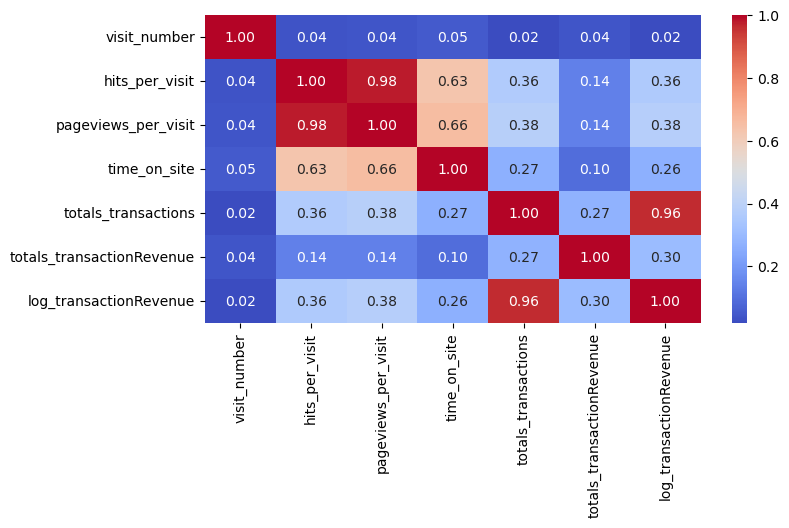

In [35]:
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

#### Observations

- High Correlation Between `hits_per_visit` and `pageviews_per_visit`: These two features have a correlation of 0.98, which is extremely high. This likely indicates redundancy, as these features may be capturing similar information. 

- Strong Correlation Between `totals_transactions` and `log_transactionRevenue`: These two features have a correlation of 0.96, meaning they are also likely redundant. 

- Moderate Correlation with `time_on_site`: time_on_site has moderate correlations with both `hits_per_visit` and `pageviews_per_visit` (0.63 and 0.66). This might indicate a relationship where users who spend more time on the site tend to have more hits or page views per visit, but it’s not as strong as the correlations mentioned above.

In [37]:
# List of columns to drop
drop_columns = ['pageviews_per_visit', 'totals_transactions']

# Drop the columns
df = df.drop(columns=drop_columns)

In [38]:
df.shape

(994870, 19)

<br>
<br>

### Categorical Correlations
#### Chi-square Test

In [40]:
# Convert boolean columns to category to include in dependency analysis
df[['bounced', 'is_weekend', 'is_holiday_season']] = df[['bounced', 'is_weekend', 'is_holiday_season']].astype('category')


In [41]:
# Select all categorical columns, including booleans
categorical_columns = df.select_dtypes(include=['category']).columns
categorical_columns

Index(['day_of_week', 'month', 'channelGrouping', 'device_category',
       'continent', 'country', 'bounced', 'trafficSource_medium', 'is_weekend',
       'quarter', 'is_holiday_season'],
      dtype='object')

In [42]:
# Perform Chi-square test for each pair of categorical features
chi2_results = []
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        chi2_results.append((col1, col2, p))

# Display results
chi2_df = pd.DataFrame(chi2_results, columns=['Feature 1', 'Feature 2', 'p-value'])
chi2_df = chi2_df.sort_values(by='p-value')
chi2_df.head(50)  # Show top pairs with the lowest p-values (indicating stronger associations)

,Feature 1,Feature 2,p-value
0,day_of_week,month,0.000000e+00
1,day_of_week,channelGrouping,0.000000e+00
2,day_of_week,device_category,0.000000e+00
3,day_of_week,continent,0.000000e+00
4,day_of_week,country,0.000000e+00
6,day_of_week,trafficSource_medium,0.000000e+00
7,day_of_week,is_weekend,0.000000e+00
8,day_of_week,quarter,0.000000e+00
12,month,continent,0.000000e+00
9,day_of_week,is_holiday_season,0.000000e+00


After analysing the correlation and the features that focus on customer behavior, engagement, and characteristics relevant for predicting revenue per customer, I will drop the following columns:

In [44]:
# List of columns to drop
drop_columns = ['date', 'quarter', 'trafficSource_medium', 'visitStartTime']

# Drop the columns
df = df.drop(columns=drop_columns)

In [45]:
df.shape

(994870, 15)

In [46]:
display(df.head())

,day_of_week,month,channelGrouping,fullVisitorId,visit_number,device_category,continent,country,hits_per_visit,bounced,time_on_site,totals_transactionRevenue,log_transactionRevenue,is_weekend,is_holiday_season
0,0,10,Organic Search,3162355547410993243,1,desktop,Europe,Germany,1,True,0,0,0.0,False,False
1,0,10,Referral,8934116514970143966,6,desktop,Americas,United States,2,False,28,0,0.0,False,False
2,0,10,Direct,7992466427990357681,1,mobile,Americas,United States,2,False,38,0,0.0,False,False
3,0,10,Organic Search,9075655783635761930,1,desktop,Asia,Turkey,2,False,1,0,0.0,False,False
4,0,10,Organic Search,6960673291025684308,1,desktop,Americas,Mexico,2,False,52,0,0.0,False,False
